In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import pysal as ps
import geopandas as gpd
import libpysal as lps
import sys
import platform
import zipfile
import os
from datetime import datetime

import seaborn as sns
sns.set(style="darkgrid") # set style

print(sys.version_info)
print("Python Version: " + str(platform.python_version()))

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
Python Version: 3.7.3


In [6]:
# modeling packages
from  statsmodels.api import OLS
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from pysal.model import *
from pysal.explore.esda.moran import Moran
from scipy import stats
from pysal.lib.weights.weights import W


In [7]:
def analyze_preds_true(preds_y, true_y):
    """Code to analyze MSE, worst errors, plot residuals"""
    resids = preds_y - true_y
    print('Residual distribution:\n',stats.describe(resids))
    print('\nMSE:',mean_squared_error(true_y, preds_y))
    ## plot 1 is just pred vs true y
    sns.scatterplot(x=preds_y, y=true_y)
    plt.xlabel("Predictions")
    plt.ylabel("True")
    plt.title("Preds vs True")
    plt.show()
    ## plot 2 is redisuals
    sns.residplot(x=preds_y, y=resids,
                  lowess=True, 
                  scatter_kws={'alpha': 0.5}, 
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.title("Residual Plots")
    plt.show()

In [8]:
## create two train and test files, 
def create_train_test(data, cols, test_year, y_col = 'log_rate'):
    prev_year = test_year - 1
    X_train_all = data.query('year!=@test_year')[cols]
    y_train_all = data.query('year!=@test_year')[y_col]
    X_train_prevyear = data.query('year==@prev_year')[cols]
    y_train_prevyear = data.query('year==@prev_year')[y_col]
    
    X_test = data.query('year==@test_year')[cols]
    y_test = data.query('year==@test_year')[y_col]
    ## quick checks
    assert X_train_all.shape[0] == len(y_train_all) 
    assert X_train_prevyear.shape[0] == len(y_train_prevyear) 
    assert X_test.shape[0] == len(y_test) 
    assert X_train_all.shape[1] == len(cols) 
    print('There are %s training obs and %s test obs' % (len(y_train_all), len(y_test)))
    
    return(X_train_all, y_train_all, X_train_prevyear, y_train_prevyear, X_test, y_test)



## Create Data
Add Malvika's data to ALL census vars

In [9]:
malvika_url = "https://raw.githubusercontent.com/malvikarajeev/sfcrimeanalysis/master/weekly_crime_counts_with_varaibles.csv"
addtl_data = pd.read_csv(malvika_url, index_col=0)
addtl_data['GEOID'] = [str(g).rjust(11, '0') for g in addtl_data['GEOID']]
addtl_data.head(5)

,year,GEOID,week,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
1,2010,06075010100,1,34,4,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
2,2010,06075010100,2,29,9,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
3,2010,06075010100,3,21,6,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
4,2010,06075010100,4,21,15,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
5,2010,06075010100,5,22,6,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472


In [10]:
yearly_agg_data = addtl_data[['year','GEOID','N','N_calls_311']].groupby(['year','GEOID']).sum().reset_index()
yearly_agg_data.head(5)

,year,GEOID,N,N_calls_311
0,2010,06075010100,1604,600
1,2010,06075010200,823,634
2,2010,06075010300,234,445
3,2010,06075010400,289,599
4,2010,06075010500,1096,663


In [11]:
census_vars = addtl_data.drop(['week','N','N_calls_311'], axis=1).groupby(['year','GEOID']).mean().reset_index()
census_vars.head(5)

,year,GEOID,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
0,2010,06075010100,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472
1,2010,06075010200,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294
2,2010,06075010300,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169
3,2010,06075010400,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725
4,2010,06075010500,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299


In [12]:
yearly_data2 = yearly_agg_data.merge(census_vars, left_on=['year','GEOID'], right_on=['year','GEOID'], how='inner')
yearly_data2.head(5)

,year,GEOID,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
0,2010,06075010100,1604,600,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472
1,2010,06075010200,823,634,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294
2,2010,06075010300,234,445,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169
3,2010,06075010400,289,599,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725
4,2010,06075010500,1096,663,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299


In [13]:
yearly_data2['rate'] = yearly_data2['N'] / yearly_data2['Estimate_Total']
yearly_data2['log_rate'] = np.log(yearly_data2['rate'])
yearly_data2.head(5)

,year,GEOID,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class,rate,log_rate
0,2010,06075010100,1604,600,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472,0.428419,-0.847654
1,2010,06075010200,823,634,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294,0.196702,-1.626067
2,2010,06075010300,234,445,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169,0.054609,-2.907555
3,2010,06075010400,289,599,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725,0.069571,-2.665400
4,2010,06075010500,1096,663,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299,0.451214,-0.795812


In [14]:
census_files = '../../data/census_tract_2009_2017.csv'
census_data = pd.read_csv(census_files, dtype={'GEOID':'str', 'year': 'int'})
census_data['GEOID'] = [g.rjust(11, '0') for g in census_data['GEOID']]
census_data.head(5)

,GEOID,NAME,year,Estimate_Total,Female,Female_10_to_14_years,Female_10th_grade,Female_11th_grade,Female_12th_grade_no_diploma,Female_15_to_17_years,...,Same_house_1_year_ago_Male,With_income,With_income_1_to_9999_or_loss,With_income_10000_to_14999,With_income_15000_to_24999,With_income_25000_to_34999,With_income_35000_to_49999,With_income_50000_to_64999,With_income_65000_to_74999,With_income_75000_or_more
0,06075010100,"Census Tract 101, San Francisco County, Califo...",2009,3685.0,1737.0,46,42,13,17,65,...,1500.0,2963.0,504,296,356.0,167,547,395,92,606.0
1,06075010100,"Census Tract 101, San Francisco County, Califo...",2010,3744.0,1927.0,40,34,14,10,61,...,1464.0,3117.0,496,354,342.0,131,562,351,231,650.0
2,06075010100,"Census Tract 101, San Francisco County, Califo...",2011,3851.0,1890.0,60,0,13,20,86,...,1567.0,3172.0,410,383,506.0,149,437,413,205,669.0
3,06075010100,"Census Tract 101, San Francisco County, Califo...",2012,3598.0,1662.0,28,0,0,17,39,...,1430.0,3008.0,392,407,425.0,175,365,337,162,745.0
4,06075010100,"Census Tract 101, San Francisco County, Califo...",2013,3741.0,1690.0,27,0,0,12,14,...,1367.0,3127.0,340,380,498.0,190,364,309,172,874.0


In [16]:
all_data = yearly_data2.merge( census_data.drop(['Estimate_Total'],axis=1), how='left', left_on=['GEOID', 'year'], right_on=['GEOID', 'year'])
all_data = all_data[np.isfinite(all_data['log_rate'])] # keep rows where log_rate isnt NA
all_data = all_data.fillna(0) # now fill all other columns with 0 
print(all_data.shape)
all_data.head(5)

(1560, 165)


,year,GEOID,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,...,Same_house_1_year_ago_Male,With_income,With_income_1_to_9999_or_loss,With_income_10000_to_14999,With_income_15000_to_24999,With_income_25000_to_34999,With_income_35000_to_49999,With_income_50000_to_64999,With_income_65000_to_74999,With_income_75000_or_more
0,2010,06075010100,1604,600,3744,0.337502,0.485310,0.936699,0.795406,0.080802,...,1464.0,3117.0,496,354,342.0,131,562,351,231,650.0
1,2010,06075010200,823,634,4184,0.362643,0.473948,0.885038,0.950765,0.438360,...,1631.0,3659.0,239,172,222.0,446,395,322,232,1631.0
2,2010,06075010300,234,445,4285,0.354192,0.501750,0.944457,0.808401,0.213598,...,1474.0,3448.0,488,231,317.0,233,510,375,133,1161.0
3,2010,06075010400,289,599,4154,0.377667,0.469186,0.931873,0.949446,0.315683,...,1501.0,3737.0,369,172,405.0,259,551,659,157,1165.0
4,2010,06075010500,1096,663,2429,0.378550,0.500206,0.942775,0.940716,0.286248,...,947.0,2255.0,160,235,209.0,61,79,187,78,1246.0


In [17]:
shapefile0 = gpd.read_file("tl_2010_06_tract10/tl_2010_06_tract10.shp")
shapefile = shapefile0.query("COUNTYFP10=='075' and ALAND10>0") # grab tracts with land 
shapefile.index = list(range(shapefile.shape[0])) # GEOID10 is match with R 
shapefile.head(5)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,+37.7741958,-122.4477884,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,06,075,016400,06075016400,164,Census Tract 164,G5020,S,309097,0,+37.7750995,-122.4369729,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,06,075,016300,06075016300,163,Census Tract 163,G5020,S,245867,0,+37.7760456,-122.4295509,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,06,075,016100,06075016100,161,Census Tract 161,G5020,S,368901,0,+37.7799831,-122.4286631,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,06,075,016000,06075016000,160,Census Tract 160,G5020,S,158236,0,+37.7823363,-122.4224838,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


In [21]:
spatial_census = pd.merge(shapefile, all_data, left_on='GEOID10', right_on='GEOID', how='inner')
spatial_census = spatial_census.select_dtypes(exclude='object')
spatial_census.head(5)

,ALAND10,AWATER10,year,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,...,Same_house_1_year_ago_Male,With_income,With_income_1_to_9999_or_loss,With_income_10000_to_14999,With_income_15000_to_24999,With_income_25000_to_34999,With_income_35000_to_49999,With_income_50000_to_64999,With_income_65000_to_74999,With_income_75000_or_more
0,370459,0,2010,630,900,4812,0.355994,0.487323,0.860973,0.892645,...,1840.0,4254.0,541,398,515.0,404,550,491,254,1101.0
1,370459,0,2011,619,1123,5098,0.345560,0.484504,0.883288,0.866613,...,1888.0,4443.0,661,454,424.0,496,452,339,342,1275.0
2,370459,0,2012,665,1239,5166,0.343240,0.500387,0.873209,0.838458,...,2136.0,4549.0,770,499,455.0,401,442,431,340,1211.0
3,370459,0,2013,871,1225,5289,0.340747,0.477973,0.883343,0.850349,...,2018.0,4581.0,640,451,397.0,467,538,498,306,1284.0
4,370459,0,2014,850,1463,5787,0.337359,0.463453,0.850527,0.864932,...,2316.0,4995.0,906,554,425.0,435,499,499,255,1422.0


In [25]:
x_cols = [c for c in list(spatial_census) if c not in ['rate','log_rate', 'N']]
X_train_all, y_train_all, X_train2016, y_train2016, X_test, y_test = create_train_test(spatial_census,
                                                                                       cols=x_cols,
                                                                                       test_year=2017)

There are 1365 training obs and 195 test obs


## Modeling with all years
1. RF
2. LR

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Residual distribution:
 DescribeResult(nobs=195, minmax=(-1.0192728222894982, 1.4096083982861334), mean=0.09104380563586166, variance=0.14276147024526464, skewness=0.12519850197904434, kurtosis=0.8745675849136822)

MSE: 0.15031833468610328


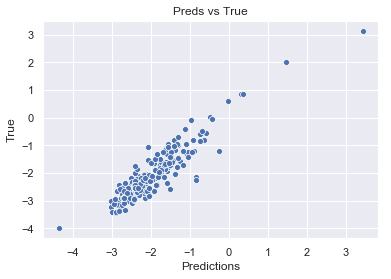

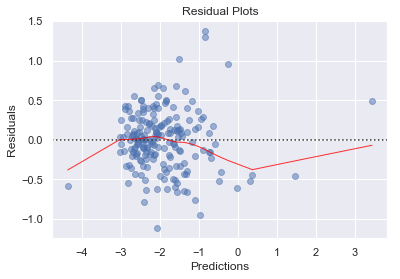

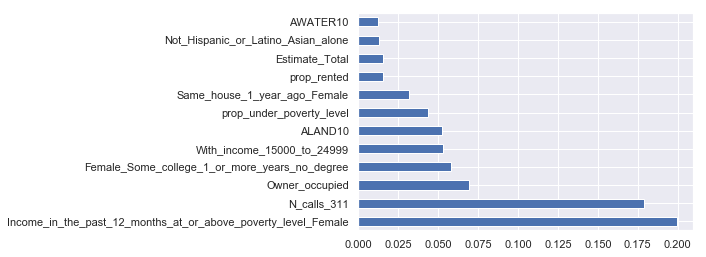

In [27]:
rf_tree = RandomForestRegressor(random_state=0)  
rf_tree.fit(X_train_all, y_train_all)  

y_pred_rf = rf_tree.predict(X_test)

analyze_preds_true(y_pred_rf, y_test)  # for model


feat_importances = pd.Series(rf_tree.feature_importances_, index=x_cols)
feat_importances.nlargest(12).plot(kind='barh')